# Train General SOM

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import pickle
import gentrl
import math

from moses.utils import CharVocab
from tqdm import tqdm
from tqdm.notebook import tqdm

import susi
from susi.SOMPlots import plot_estimation_map, plot_som_histogram, plot_umatrix
! mkdir SOMs

In [ ]:
df = pd.read_csv("./data/train_ligase_2_filtered.csv")
df = df[df['Standard Units'] == 'nM']
df.to_csv('train_ligase_filtered.csv', index=None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,14,18,19,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df = pd.read_csv("./data/train_ligase_filtered.csv")
vocab = CharVocab.from_data(df['Smiles'])
smiles = []
for i in df["Smiles"]:
    smiles.append(gentrl.tokenizer.encode([i], vocab)[0][0])

smiles = np.array([i.numpy() for i in smiles])

In [ ]:
df['Standard Value'].max()

1636745900.0

In [ ]:
values = []
for i in df['Standard Value']:
  values.append(-math.log(i * 1e-9))

print(max(values), min(values))
values = np.array(values)

22.283913585211078 -0.4927100633718207


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(smiles), np.array(values),
    test_size=0.1, random_state=20, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2269, 101) (253, 101) (2269,) (253,)


In [ ]:
print(max(y_train), min(y_train))
print(max(y_test), min(y_test))

22.283913585211078 -0.4927100633718207
20.72326583694641 7.226859221442258


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    "n_rows": [10,30,50],
    "n_columns": [10,30,50],
}
som = susi.SOMRegressor(
    n_iter_unsupervised=10000,
    n_iter_supervised=5000,
    neighborhood_mode_unsupervised="min",
    neighborhood_mode_supervised="min",
    learn_mode_unsupervised="min",
    learn_mode_supervised="min",
    n_jobs=1,
    learning_rate_start=0.42,
    learning_rate_end=0.11,
    verbose=0)

clf = RandomizedSearchCV(som, param_grid, random_state=1)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'n_rows': 50, 'n_columns': 50}
0.38824876120063045


In [ ]:
som = susi.SOMRegressor(
    n_rows=100,
    n_columns=100,
    n_iter_unsupervised=1000000,
    n_iter_supervised=1000000,
    #missing_label_placeholder=-1,
    neighborhood_mode_unsupervised="min",
    neighborhood_mode_supervised="min",
    learn_mode_unsupervised="min",
    learn_mode_supervised="min",
    learning_rate_start=0.42,
    learning_rate_end=0.11,
    random_state=1,
    n_jobs=1,
    verbose=1)

In [ ]:
som.fit(X_train, y_train)

super: 100%|████████████████████████████████████████████| 1000000/1000000 [15:16<00:00, 1091.18it/s]


SOMRegressor(distance_metric='euclidean', init_mode_supervised='random',
             init_mode_unsupervised='random', learn_mode_supervised='min',
             learn_mode_unsupervised='min', learning_rate_end=0.11,
             learning_rate_start=0.42, missing_label_placeholder=None,
             n_columns=100, n_iter_supervised=1000000,
             n_iter_unsupervised=1000000, n_jobs=1, n_rows=100,
             nbh_dist_weight_mode='pseudo-gaussian',
             neighborhood_mode_supervised='min',
             neighborhood_mode_unsupervised='min', random_state=1,
             train_mode_supervised='online', train_mode_unsupervised='online',
             verbose=1)

In [ ]:
train_score = som.score(X_train, y_train)
test_score = som.score(X_test, y_test)
print("\nTrain: {0:.2f} %".format(train_score*100))
print("Test: {0:.2f} %".format(test_score*100))

predict: 100%|███████████████████████████████████████████████████| 253/253 [00:01<00:00, 183.25it/s]


Train: 92.60 %
Test: 58.91 %


In [ ]:
pickle.dump(som, open("./SOMs/general_som_1M.p", "wb"))

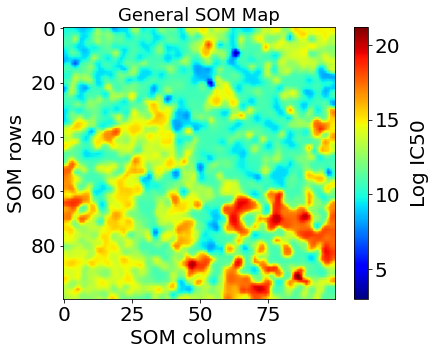

max value: 21.202759362355124


In [ ]:
estimation_map = np.squeeze(som.get_estimation_map())
plot_estimation_map(
    estimation_map, cbar_label="Log IC50", cmap="jet")
plt.title("General SOM Map",  fontsize=20)
plt.show()
print('max value:', estimation_map.max())

# Train Specific SOM

In [ ]:
df = pd.read_csv("./data/train_ic50_3_filtered.csv")

In [ ]:
vocab = CharVocab.from_data(df['Smiles'])
smiles = []
for i in df["Smiles"]:
    smiles.append(gentrl.tokenizer.encode([i], vocab)[0][0])

smiles = np.array([i.numpy() for i in smiles])
values = list(df["Standard Value"])

In [ ]:
print(max(values), min(values))

6.197 4.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(smiles), np.array(values),
    test_size=0.1, random_state=42, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1172, 101) (131, 101) (1172,) (131,)


In [ ]:
print(max(y_train), min(y_train))
print(max(y_test), min(y_test))

6.197 4.0
5.9639999999999995 4.0


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_iter_unsupervised':[10000, 20000, 30000],
    'n_iter_supervised':[5000,10000,20000],
}
som = susi.SOMRegressor(n_rows=50,
    n_columns=50,
    n_iter_unsupervised=10000,
    n_iter_supervised=5000,
    neighborhood_mode_unsupervised="min",
    neighborhood_mode_supervised="min",
    learn_mode_unsupervised="min",
    learn_mode_supervised="min",
    learning_rate_start=0.7,
    learning_rate_end=0.125,
    n_jobs=1,
    verbose=0)

clf = RandomizedSearchCV(som, param_grid,random_state=1)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'n_iter_unsupervised': 30000, 'n_iter_supervised': 20000}
0.5316352752211184


In [ ]:
som = susi.SOMRegressor(
    n_rows=100,
    n_columns=100,
    n_iter_unsupervised=800000,
    n_iter_supervised=800000,
    neighborhood_mode_unsupervised="min",
    neighborhood_mode_supervised="min",
    learn_mode_unsupervised="min",
    learn_mode_supervised="min",
    learning_rate_start=0.7,
    learning_rate_end=0.125,
    random_state=1,
    n_jobs=1,
    verbose=1)

In [ ]:
som.fit(X_train, y_train)

super: 100%|██████████████████████████████████████████████| 800000/800000 [11:30<00:00, 1158.57it/s]


SOMRegressor(distance_metric='euclidean', init_mode_supervised='random',
             init_mode_unsupervised='random', learn_mode_supervised='min',
             learn_mode_unsupervised='min', learning_rate_end=0.125,
             learning_rate_start=0.7, missing_label_placeholder=None,
             n_columns=100, n_iter_supervised=800000,
             n_iter_unsupervised=800000, n_jobs=1, n_rows=100,
             nbh_dist_weight_mode='pseudo-gaussian',
             neighborhood_mode_supervised='min',
             neighborhood_mode_unsupervised='min', random_state=1,
             train_mode_supervised='online', train_mode_unsupervised='online',
             verbose=1)

In [ ]:
train_score = som.score(X_train, y_train)
test_score = som.score(X_test, y_test)
print("\nTrain: {0:.2f} %".format(train_score*100))
print("Test: {0:.2f} %".format(test_score*100))

predict: 100%|███████████████████████████████████████████████████| 131/131 [00:00<00:00, 183.22it/s]


Train: 92.56 %
Test: 77.76 %


In [ ]:
pickle.dump(som, open("./SOMs/specific_som_800K.p", "wb"))

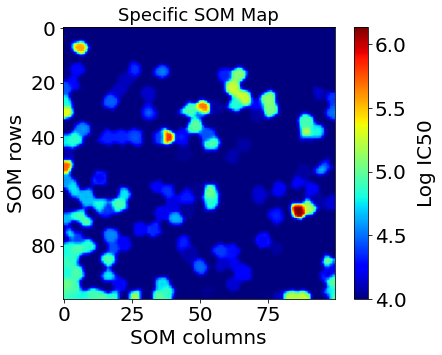

max value: 6.136587935156932


In [ ]:
estimation_map = np.squeeze(som.get_estimation_map())
plot_estimation_map(
    estimation_map, cbar_label="Log IC50", cmap="jet")
plt.title("Specific SOM Map",  fontsize=20)
plt.show()
print('max value:', estimation_map.max())

# Plot Heatmap

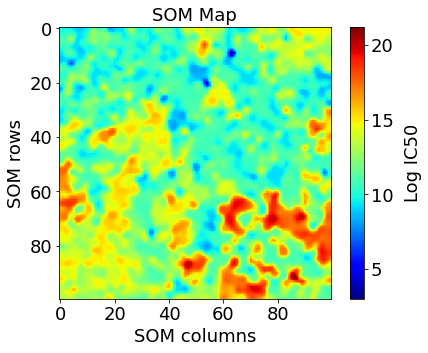

max value: 21.202759362355124


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pickle
import susi
from susi.SOMPlots import plot_estimation_map, plot_som_histogram, plot_umatrix

som_file = './SOMs/general_som_1M.p'
#som_file = './SOMs/specific_som_800K.p'
som = pickle.load(open(som_file, "rb"))

estimation_map = np.squeeze(som.get_estimation_map())
plot_estimation_map(
    estimation_map, cbar_label="Log IC50", cmap="viridis", fontsize=20)
plt.title("SOM Map",  fontsize=20)
plt.savefig(f'{som_file[7:-2]}_heatmap.png')
plt.show()
print('max value:', estimation_map.max())